## Import the Necessary Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, jaccard_score
from joblib import Parallel, delayed

## Prepare the Dataset

In [2]:
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    annotations = []
    for obj in root.findall('object'):
        filename = root.find('filename').text
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        coords = {
            'xmin': int(bbox.find('xmin').text),
            'ymin': int(bbox.find('ymin').text),
            'xmax': int(bbox.find('xmax').text),
            'ymax': int(bbox.find('ymax').text)
        }
        annotations.append({'filename': filename, 'label': label, 'bbox': coords})
    return annotations

In [3]:
ANNOTATION_PATH = 'annotations'
xml_files = [os.path.join(ANNOTATION_PATH, filename) for filename in os.listdir(ANNOTATION_PATH)]

data = []
for xml_file in xml_files:
    annotations = parse_xml(xml_file)

    for annotation in annotations:
        data.append([annotation['filename'], annotation['label'], annotation['bbox']])

df = pd.DataFrame(data, columns=['filename', 'label', 'bbox'])
df['label'].value_counts()

label
with_mask                3232
without_mask              717
mask_weared_incorrect     123
Name: count, dtype: int64

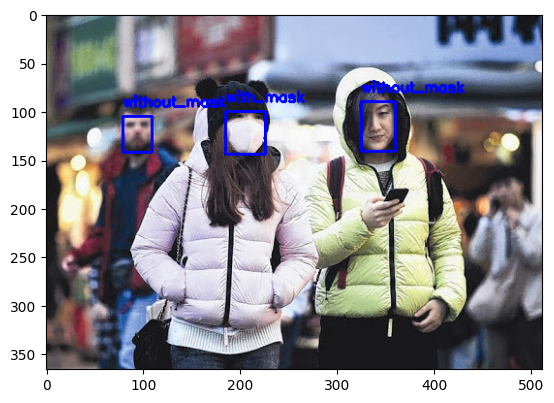

In [4]:
def visualize_annotation(image_path, annotations):
    image = cv2.imread(image_path)

    for ann in annotations:
        bbox = ann['bbox']
        cv2.rectangle(image, (bbox['xmin'], bbox['ymin']), (bbox['xmax'], bbox['ymax']), (255, 0, 0), 2)
        cv2.putText(image, ann['label'], (bbox['xmin'], bbox['ymin'] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
visualize_annotation('images/maksssksksss0.png', parse_xml('annotations/maksssksksss0.xml'))

In [5]:
import cv2
import numpy as np
from keras.preprocessing.image import img_to_array
from keras.applications.mobilenet_v2 import preprocess_input
from joblib import Parallel, delayed

IMAGE_PATH = 'images/'
label_pair = {
    'with_mask': 0,
    'without_mask': 1,
    'mask_weared_incorrect': 2
}

def process_image(row):
    bbox = row['bbox']
    image = cv2.imread(IMAGE_PATH + row['filename'])
    image = image[bbox['ymin']:bbox['ymax'], bbox['xmin']:bbox['xmax']]
    image = cv2.resize(image, (224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    label = label_pair[row['label']]
    return image, label

results = Parallel(n_jobs=-1)(delayed(process_image)(df.iloc[i]) for i in range(len(df)))

face_images, face_labels = zip(*results)
face_images = np.array(face_images, dtype='float32')
face_labels = np.array(face_labels)

In [ ]:
augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

## Define the Model

In [8]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input, EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, jaccard_score
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed

IMAGE_PATH = 'images/'
label_pair = {
    'with_mask': 0,
    'without_mask': 1,
    'mask_weared_incorrect': 2
}

def process_image(row):
    bbox = row['bbox']
    image = cv2.imread(IMAGE_PATH + row['filename'])
    image = image[bbox['ymin']:bbox['ymax'], bbox['xmin']:bbox['xmax']]
    image = cv2.resize(image, (224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    label = label_pair[row['label']]
    return image, label

results = Parallel(n_jobs=-1)(delayed(process_image)(df.iloc[i]) for i in range(len(df)))

face_images, face_labels = zip(*results)
face_images = np.array(face_images, dtype='float32')
face_labels = np.array(face_labels)

# Convert labels to one-hot encoding
face_labels = np.eye(3)[face_labels]

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(face_images, face_labels, test_size=0.2, random_state=42)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load pre-trained EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)  # Add dropout for regularization
predictions = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with categorical cross-entropy loss
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and saving the best model
callbacks = [
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min'),
    EarlyStopping(monitor='val_loss', patience=10, mode='min')
]

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val),
                    epochs=50,
                    callbacks=callbacks)

# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training the model
history_fine = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                         validation_data=(X_val, y_val),
                         epochs=50,
                         callbacks=callbacks)

# Make predictions on the validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Compute metrics function
def compute_metrics(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])

    # Initialize metrics
    dice_scores = []
    sensitivities = []
    specificities = []
    accuracies = []

    for i in range(len(cm)):
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp
        fp = np.sum(cm[:, i]) - tp
        tn = np.sum(cm) - (tp + fn + fp)

        # Dice Score (F1 Score for segmentation)
        dice_score = (2 * tp) / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 0
        dice_scores.append(dice_score)

        # Sensitivity (Recall or True Positive Rate)
        sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
        sensitivities.append(sensitivity)

        # Specificity (True Negative Rate)
        specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
        specificities.append(specificity)

        # Accuracy
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        accuracies.append(accuracy)

    # Jaccard Index (IoU)
    jaccard = jaccard_score(y_true, y_pred, average='macro')  # Use 'macro' for multiclass

    return {
        "Dice Score": np.mean(dice_scores),
        "Jaccard Index": jaccard,
        "Sensitivity": np.mean(sensitivities),
        "Specificity": np.mean(specificities),
        "Accuracy": np.mean(accuracies)
    }

# Compute metrics using the true and predicted labels
metrics = compute_metrics(y_true_classes, y_pred_classes)
print(metrics)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 84s 723ms/step - accuracy: 0.8033 - loss: 0.5414 - val_accuracy: 0.8650 - val_loss: 0.3351
Epoch 2/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 72s 693ms/step - accuracy: 0.8654 - loss: 0.3583 - val_accuracy: 0.8859 - val_loss: 0.3042
Epoch 3/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 72s 686ms/step - accuracy: 0.8838 - loss: 0.3321 - val_accuracy: 0.8675 - val_loss: 0.3645
Epoch 4/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 74s 707ms/step - accuracy: 0.8930 - loss: 0.3071 - val_accuracy: 0.8945 - val_loss: 0.2915
Epoch 5/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 71s 678ms/step - accuracy: 0.8981 - loss: 0.2670 - val_accuracy: 0.9067 - val_loss: 0.2645
Epoch 6/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 71s 687ms/step - accuracy: 0.8971 - loss: 0.2735 - val_accuracy: 0.9055 - val_loss: 0.2654
Epoch 7/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 71s 682ms/step - accuracy: 0.8775 - loss: 0.3269 - val_accuracy: 0.8994 - val_loss: 0.2903
Epoch 8/50
102/102 ━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


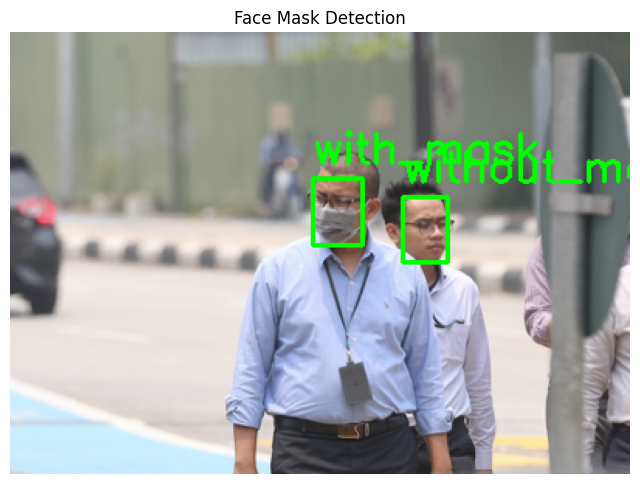

In [66]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the best saved model
best_model = load_model('best_model.keras')

# Load the face detection model
model_path = "deploy.prototxt"  # Replace with your prototxt path
weights_path = "res10_300x300_ssd_iter_140000.caffemodel"  # Replace with your caffemodel path
face_net = cv2.dnn.readNetFromCaffe(model_path, weights_path)

# Label mapping
label_pair_reversed = {
    0: 'with_mask',
    1: 'without_mask',
    2: 'mask_weared_incorrect'
}

def predict_image(filepath):
    image = cv2.imread(filepath)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, scalefactor=1.0, size=(300, 300), mean=(104.0, 177.0, 123.0))
    face_net.setInput(blob)
    detections = face_net.forward()

    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.2:  # Threshold for confidence
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # Ensure the bounding box is within the dimensions of the image
            startX = max(0, startX)
            startY = max(0, startY)
            endX = min(w, endX)
            endY = min(h, endY)

            face = image[startY:endY, startX:endX]
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = np.expand_dims(face, axis=0)
            face = preprocess_input(face)
            label = best_model.predict(face)
            label = np.argmax(label, axis=1)[0]

            # Draw bounding box and label on the image
            cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)
            cv2.putText(image, label_pair_reversed[label], (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Display the image in the notebook
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Face Mask Detection")
    plt.show()

# Test the model with a new image
predict_image('img/img3.png')

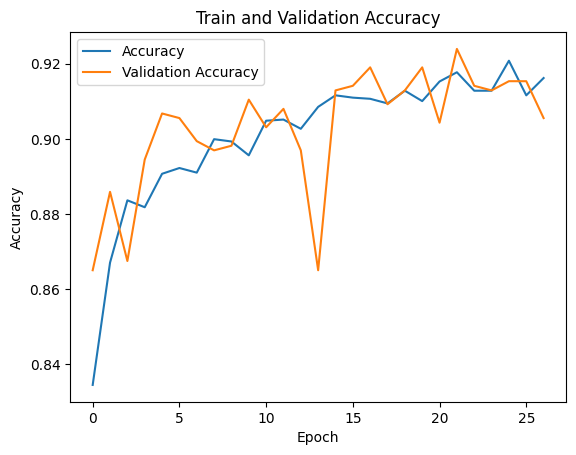

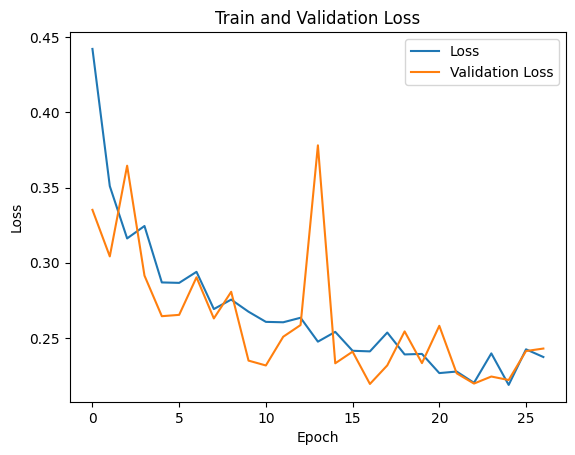

In [ ]:
# Plot training & validation accuracy values
plt.figure()
plt.title('Train and Validation Accuracy')
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Plot training & validation loss values
plt.figure()
plt.title('Train and Validation Loss')
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [13]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

--2025-02-28 16:44:57--  https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8001::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28104 (27K) [text/plain]
Saving to: 'deploy.prototxt.1'

     0K .......... .......... .......                         100% 3.02M=0.009s

2025-02-28 16:44:58 (3.02 MB/s) - 'deploy.prototxt.1' saved [28104/28104]

--2025-02-28 16:44:58--  https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
Resolving github.com (github.com)... 20.207.73.82
Connecting to github.com (github.com)|20.207.73.82|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/opencv/o